In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [79]:
!pip install patchify
!pip install linformer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

In [83]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import Layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from linformer import LinformerSelfAttention

In [4]:
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

In [5]:
class ClassToken(Layer):
  def __init__(self):
    super().__init__()

  def build(self,input_shape):
    w_init = tf.random_normal_initializer()
    self.weight = tf.Variable(
        initial_value = w_init(shape=(1,1,input_shape[-1]),dtype=tf.float32),
        trainable = True
    )

  def call(self,inputs):
    batch_size=tf.shape(inputs)[0]
    hidden_dim = self.weight.shape[-1]

    cls=tf.broadcast_to(self.weight,[batch_size,1,hidden_dim])
    cls = tf.cast(cls,dtype=inputs.dtype)
    return cls

In [84]:
def mlp(x,cf):
    x=Dense(cf["mlp_dim"],activation='gelu')(x)
    x=Dropout(cf["dropout_rate"])(x)
    x=Dense(cf["hidden_dim"])(x)
    x=Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x,cf):
    l_1 = x
    x= LayerNormalization()(x)
    x = LinformerSelfAttention(dim=cf["hidden_dim"], seq_len=cf["num_patches"] + 1,  # +1 for class token
                                 heads=cf["num_heads"], k=256)(x) #x1-query,x2-key,value
    x=Add()([x,l_1])

    l_2 =x
    x = LayerNormalization()(x)
    x=mlp(x,cf)
    x=Add()([x,l_2])

    return x

In [7]:
def ViT(cf):
  #inputs
  input_shape=(cf["num_patches"],cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
  inputs =Input(input_shape)

  #patch+postional embeddings
  patch_embed = Dense(cf["hidden_dim"])(inputs)
  positions = tf.range(start=0,limit=cf["num_patches"],delta=1)
  pos_embed = Embedding(input_dim=cf["num_patches"],output_dim=cf["hidden_dim"])(positions)
  embed = patch_embed + pos_embed

  #add calss token
  token = ClassToken()(embed)
  x = Concatenate(axis=1)([token,embed])

  #transformer encoder
  for _ in range(cf["num_layers"]):
    x=transformer_encoder(x,cf)

  #classification head
  x = LayerNormalization()(x)
  x =x[:,0,:]
  x=Dense(cf["num_classes"],activation="softmax")(x)

  model = Model(inputs,x)
  return model

In [ ]:
if __name__ == "__main__":
    config = {}
    config["num_layers"] = 8
    config["mlp_dim"] = 1536
    config["hidden_dim"] = 512
    config["num_heads"] = 8
    config["dropout_rate"] = 0.3
    config["num_patches"] = 256
    config["patch_size"] = 16
    config["num_channels"] = 3
    config["num_classes"] = 4

    model = ViT(config)
    model.summary()

In [82]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split as tts
from patchify import patchify
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [66]:
# Hyperparameters
hp = {}

hp["num_channels"] = 3
hp["patch_size"] = 16
hp["image_size"] = 256
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 32
hp["lr"] = 5e-5
hp["num_epochs"] = 15
hp["num_classes"] = 4
hp["class_names"] = ["Corn___Common_Rust", "Corn___Gray_Leaf_Spot", "Corn___Healthy", "Corn___Northern_Leaf_Blight"]

hp["num_layers"] = 8
hp["hidden_dim"] = 512
hp["mlp_dim"] = 1536
hp["num_heads"] = 8
hp["dropout_rate"] = 0.3

In [11]:
#Technique No.1
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

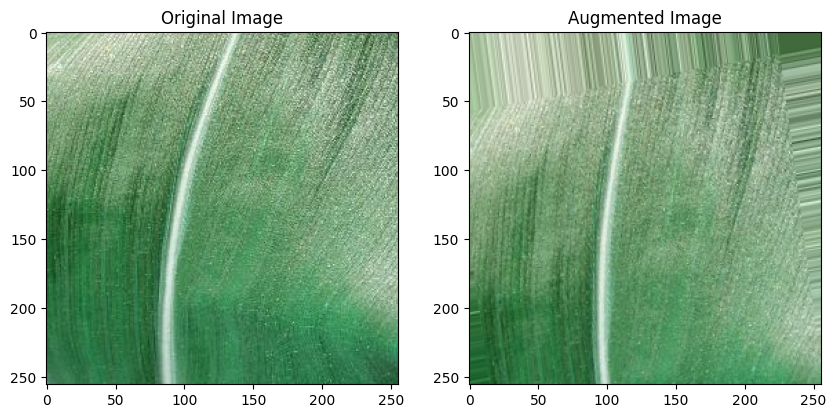

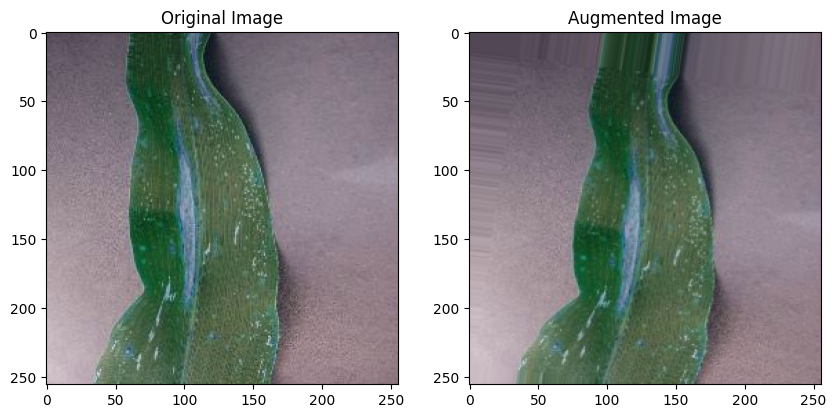

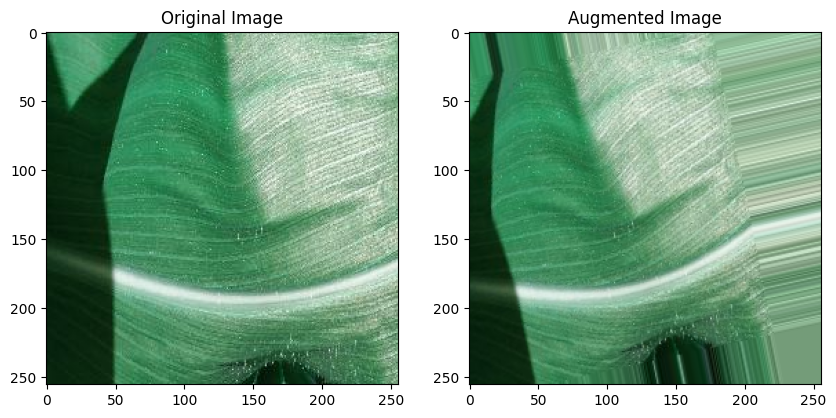

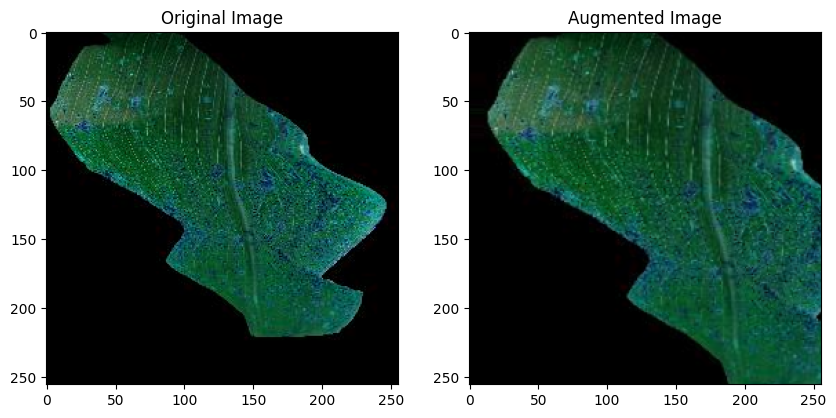

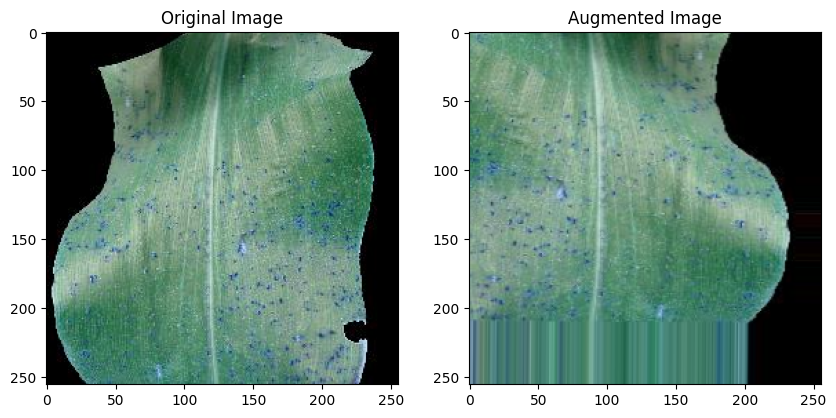

In [77]:
# Technique -2
import matplotlib.pyplot as plt

# Create a sample of images
sample_images = x_train[:5]  # Take the first 5 training images

# Create an ImageDataGenerator instance (same as your 'datagen')
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
for image_path in sample_images:
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image / 255.0

    # Apply augmentation using datagen.flow
    augmented_images = datagen.flow(np.expand_dims(image, axis=0), batch_size=1)

    # Display original and augmented images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[0][0])  # Get the first augmented image
    plt.title("Augmented Image")

    plt.show()

In [57]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path,split=0.1):
  images = shuffle(glob(os.path.join(path,"*","*.*")))
  split_size = max(1,int(len(images)*split))

  x_train,x_val = tts(images,test_size=split_size,random_state=42)
  x_train,x_test = tts(x_train,test_size=split_size,random_state=42)
  return x_train,x_val,x_test

In [58]:
def process_image_label(path):
        path = path.decode()
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
        # Apply data augmentation using ImageDataGenerator
        image = datagen.random_transform(image)
        image = image / 255.0

        patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
        patches = patchify(image, patch_shape, hp["patch_size"])
        patches = np.reshape(patches, hp["flat_patches_shape"])
        patches = patches.astype(np.float32)

        class_name = path.split("/")[-2]
        class_idx = hp["class_names"].index(class_name)
        class_idx = np.array(class_idx, dtype=np.int32)

        return patches, class_idx

In [59]:
def augment_image(patches):
    # Reshape to image dimensions for ImageDataGenerator
    image_shape = (
        hp["image_size"],
        hp["image_size"],
        hp["num_channels"],
    )
    images = tf.reshape(patches, image_shape)

    # Apply augmentation
    augmented_images = tf.numpy_function(
        datagen.random_transform, [images], tf.float32
    )

    # Reshape back to patches
    augmented_patches = tf.reshape(augmented_images, (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"]))  # Reshape back to original patch shape
    return augmented_patches

In [60]:
def parse(path):
  patches,labels = tf.numpy_function(process_image_label,[path],[tf.float32,tf.int32])
  labels = tf.one_hot(labels,hp["num_classes"])

  patches = tf.ensure_shape(patches, hp["flat_patches_shape"])
  labels.set_shape(hp["num_classes"])

  return patches,labels

def tf_dataset(images,batch=32):
  ds = tf.data.Dataset.from_tensor_slices((images))
  ds = ds.map(parse)
  ds = ds.map(lambda patches, labels: (augment_image(patches), labels))  # Move augment_image before batch
  ds = ds.batch(batch).prefetch(8) # Batch after augment_image
  return ds


In [61]:
def predict(path):
  image = cv2.imread(path,cv2.IMREAD_COLOR)
  image = cv2.resize(image,(hp["image_size"],hp["image_size"]))
  image = image/255.0

  patch_shape =(hp["patch_size"],hp["patch_size"],hp["num_channels"])
  patches = patchify(image,patch_shape,hp["patch_size"])
  patches = np.reshape(patches,hp["flat_patches_shape"])
  patches = patches.astype(np.float32)

  pre =model.predict(np.expand_dims(patches,axis=0))
  result = np.argmax(pre[0])
  return hp["class_names"][result]

In [67]:
if __name__ == "__main__":
  np.random.seed(42)
  tf.random.set_seed(42)

  create_dir("files")

  dfpath = "/content/drive/MyDrive/Crop___Disease/Corn"
  model_path = os.path.join("files","model.h5")
  csv_path = os.path.join("files","log.csv")

  x_train,x_val,x_test = load_data(dfpath,0.15)
  print(f"Train: {len(x_train)} - Val: {len(x_val)} - Test: {len(x_test)}")

  train_ds = tf_dataset(x_train,batch=hp["batch_size"])
  val_ds = tf_dataset(x_val,batch=hp["batch_size"])

  print(f"Train: {len(train_ds)} - Val: {len(val_ds)}")

  optimizer = tf.keras.optimizers.Adam(hp["lr"])
  optimizer = mixed_precision.LossScaleOptimizer(optimizer)

  model = ViT(hp)
  model.compile(
      loss = "categorical_crossentropy",
      optimizer = optimizer,
      metrics = ["acc"]
  )

  callbacks = [
        ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-8, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=False),
    ]

  from tensorflow.keras.callbacks import TensorBoard
  tensorboard_callback = TensorBoard(log_dir="./logs", histogram_freq=1)

  history=model.fit(
        train_ds,
        epochs=hp["num_epochs"],
        validation_data=val_ds,
  )

Train: 2698 - Val: 577 - Test: 577
Train: 85 - Val: 19
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - acc: 0.4246 - loss: 2.0525 - val_acc: 0.6205 - val_loss: 0.9065
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - acc: 0.7586 - loss: 0.5876 - val_acc: 0.7487 - val_loss: 0.4885
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - acc: 0.8053 - loss: 0.4532 - val_acc: 0.8406 - val_loss: 0.3239
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - acc: 0.8273 - loss: 0.3864 - val_acc: 0.8440 - val_loss: 0.2920
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - acc: 0.8387 - loss: 0.3474 - val_acc: 0.8319 - val_loss: 0.3677
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - acc: 0.8235 - loss: 0.3635 - val_acc: 0.8562 - val_loss: 0.2893
Epoch 7/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - acc: 0.8496 - loss: 0.3292 - val_acc: 0.8527 - val_loss: 0.2936
Epoch 8/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - acc: 0.8445 - loss: 0.3368 - val_acc: 0.8406 - val_loss: 0.3318
Epoch 9/2

In [38]:
y_train = [hp["class_names"].index(img.split("/")[-2]) for img in x_train]
y_val = [hp["class_names"].index(img.split("/")[-2]) for img in x_val]
y_test = [hp["class_names"].index(img.split("/")[-2]) for img in x_test]

In [68]:
# Evaluate the model
test_ds = tf_dataset(x_test, batch=hp["batch_size"])  # Create a dataset for test data
score = model.evaluate(test_ds, verbose=0)
print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

Test Loss:  0.31456252932548523
Test Accuracy:  0.8336221575737


In [71]:
# Plot training & validation accuracy values using Plotly
import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(50)), y=history.history['acc'], mode='lines+markers', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(50)), y=history.history['val_acc'], mode='lines+markers', name='Val Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

In [73]:
# Plot training & validation loss values using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(20)), y=history.history['loss'], mode='lines+markers', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(20)), y=history.history['val_loss'], mode='lines+markers', name='Val Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [75]:
# Predict an image
image_path = "/content/drive/MyDrive/Crop___Disease/Corn/Corn___Common_Rust/image (1077).JPG"

# Load and preprocess the image using the predict function defined earlier
predicted_class_name = predict(image_path) # Call the predict function with the image path

print("Predicted class:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted class: Corn___Common_Rust
